In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')
items = pd.read_csv('../input/items.csv')
item_cats = pd.read_csv('../input/item_categories.csv')
shops = pd.read_csv('../input/shops.csv')

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
#check if all shop and items in the test set is also in the training set.
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [3]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

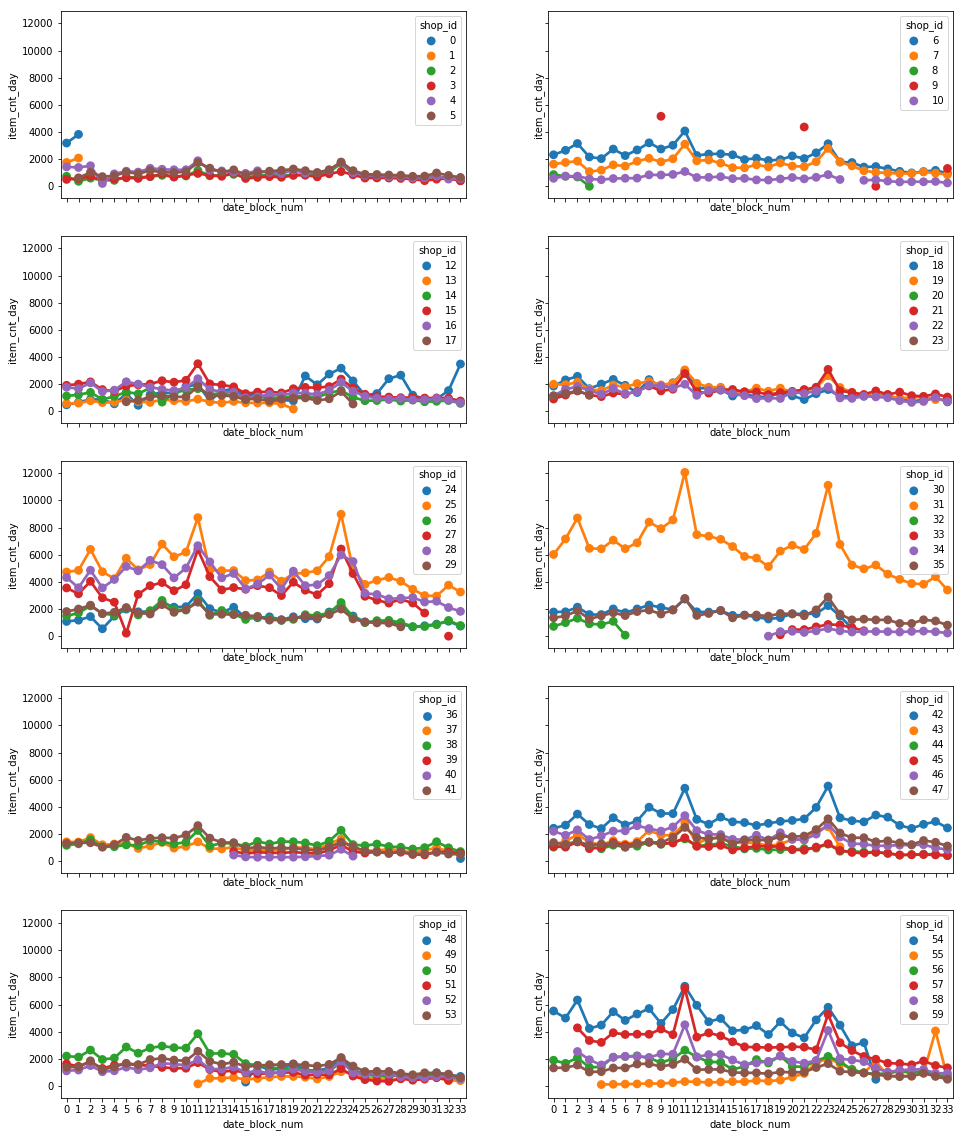

In [4]:
#shop and item categories.
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [5]:
#Clearly, there is a peak in shop shop at the end of the year, 
#probably due to the holiday season. 
#Therefore, it would be beneficial to add month and year, 
#so that the network can pickup this pattern. 
#It would be nice to see how each item sale is going. 
#However, given the number of items, it would be more beneficial if we look 
#at how each item categories is doing instead.

# add categories
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()


In [6]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

/home/rohith/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


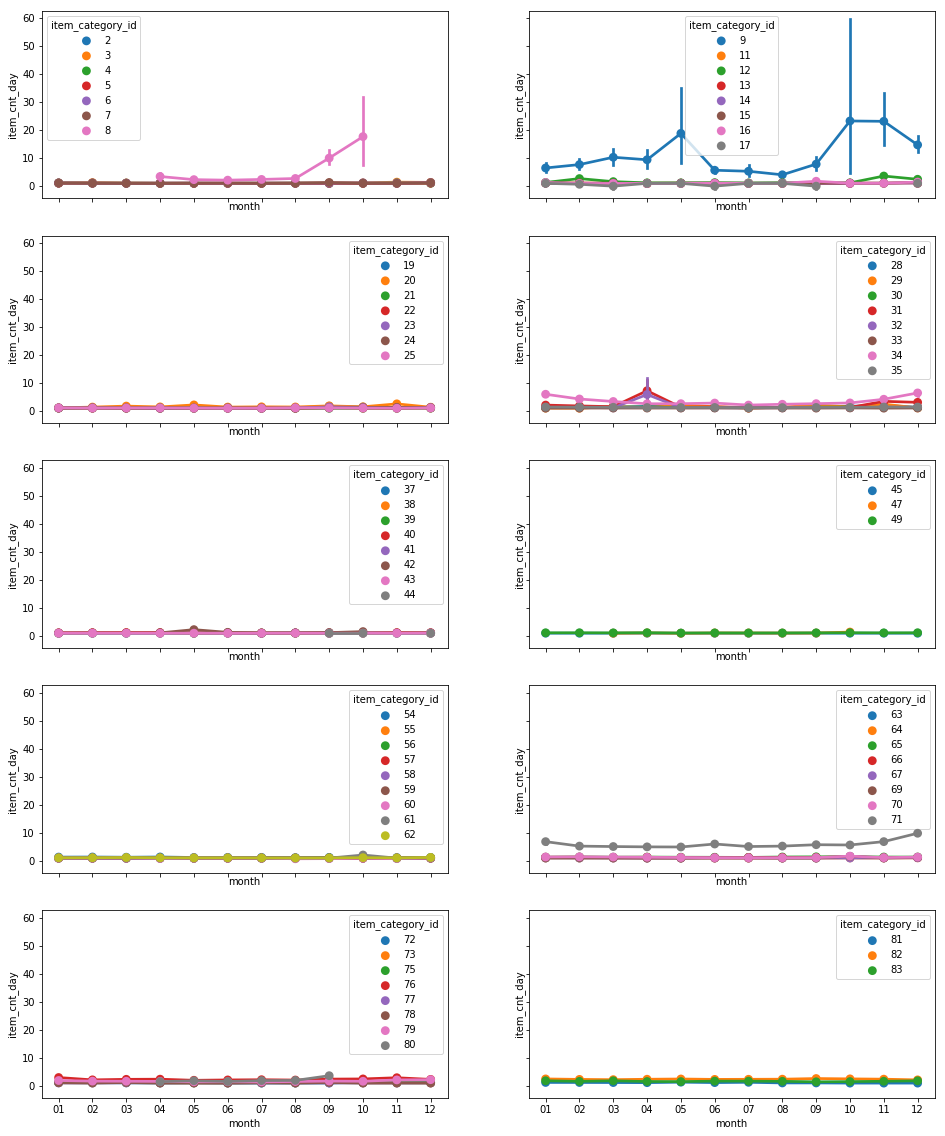

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

/home/rohith/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


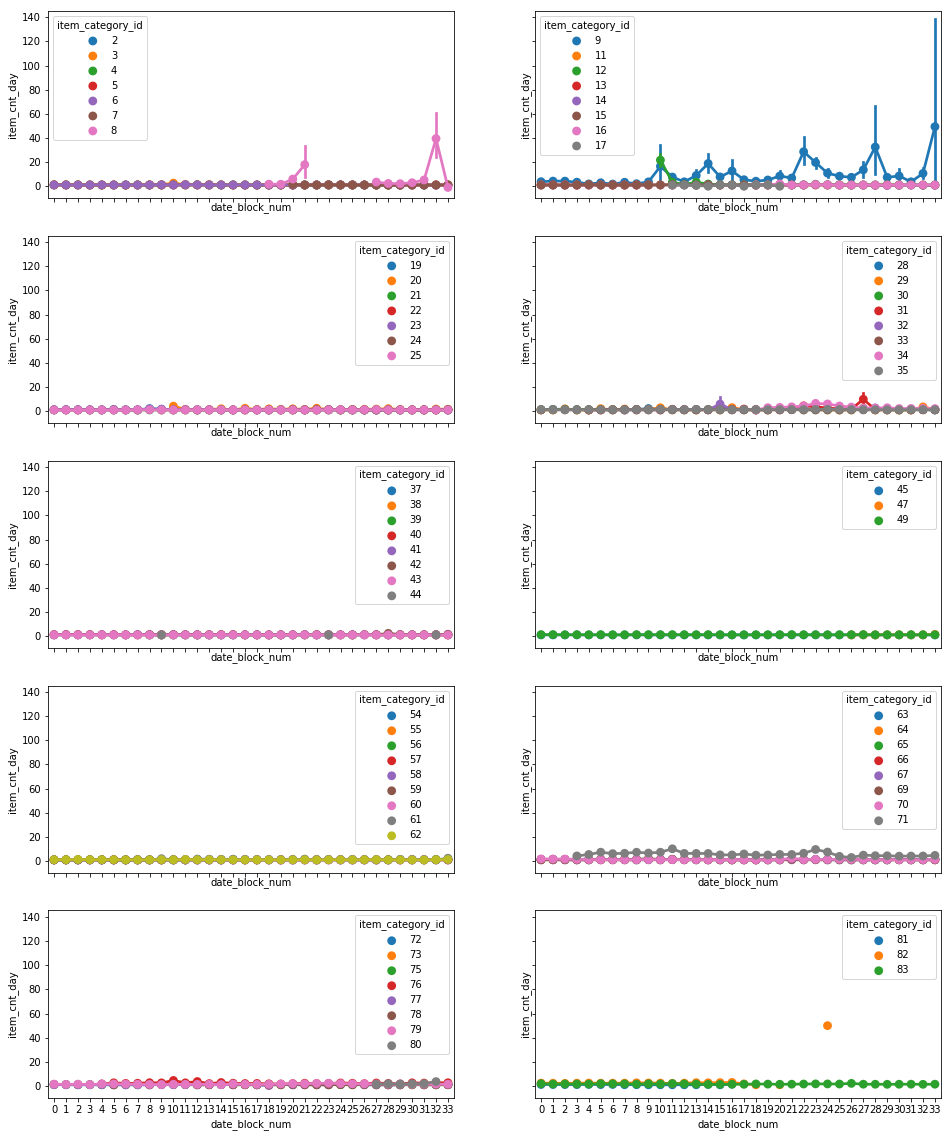

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [9]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

In [10]:
#In gradient based learning method, it is common to normalize the numerical variable to speed up the training

scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.as_matrix().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.as_matrix().reshape(-1, 1))

'''

It is natural to try to encode the whole training set to feed to the network. However, this approach has two drawbacks:

    It is unlikely that sale data from Jan 2013 or any time close by has any effect with sale of Nov 2015.
    The memory requirements exceed the limit that Kaggle provides.

We would instead learn the sequence of July, August, September, October, November in 2013 and 2014.

'''

/home/rohith/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/rohith/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/rohith/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/rohith/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


'\n\nIt is natural to try to encode the whole training set to feed to the network. However, this approach has two drawbacks:\n\n    It is unlikely that sale data from Jan 2013 or any time close by has any effect with sale of Nov 2015.\n    The memory requirements exceed the limit that Kaggle provides.\n\nWe would instead learn the sequence of July, August, September, October, November in 2013 and 2014.\n\n'

In [11]:
#Not every item is saled in the above time period, 
#we will add a record for them with item_cnt_day as 0. 
#The price is a little bit tricky. 
#As can be seen at the code below, price of an item depends on shop and point of time. 
#We will fill in empty values with the closest past record.

train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()



item_price  item_cnt_day        ID
item_id date_block_num shop_id                                    
28      0              15        -0.210680     -0.167284     57746
                       31        -0.049171      0.023276    196263
                       35        -0.210680     -0.167284     69716
                       46        -0.210680     -0.167284    115642
                       47        -0.129926     -0.072004    187527
        1              4         -0.232891     -0.167284    163446
                       19        -0.232891     -0.167284    145884
                       35        -0.152137     -0.072004    374081
                       46        -0.174348     -0.072004    392641
                       47        -0.232891     -0.167284    126717
        2              23        -0.232891     -0.167284    288246
                       29        -0.232891     -0.167284    317729
                       38        -0.232891     -0.167284    229760
                       43        -0.174348     -0.072004    542357
                       44        -0.232891     -0.167284    226249
                       50        -0.232891     -0.167284    266437
        3              12        -0.232891     -0.167284    366739
                       21        -0.232891     -0.167284    352569
                       22        -0.232891     -0.167284    381183
                       27        -0.232891     -0.167284    365306
                       51        -0.240393     -0.167284    397776
                       53        -0.232891     -0.167284    386652
        4              19        -0.232891     -0.167284    514747
                       24        -0.232891     -0.167284    452085
                       41        -0.232891     -0.167284    467485
                       46        -0.115805     -0.167284   1406868
        5              28        -0.247601     -0.167284    587738
                       30        -0.247601     -0.167284    534300
                       47        -0.247601     -0.167284    622921
                       50        -0.247601     -0.167284    616562
...                                    ...           ...       ...
22167   31             26        -0.247454     -0.167284   2820001
                       31        -0.247454     -0.167284   2785048
                       35        -0.247454     -0.167284   2783441
                       39        -0.247454     -0.167284   2786827
                       42        -0.159492      0.023276   8335314
                       52        -0.203473     -0.072004   5605211
        32             12        -0.027549      0.309117  17189704
                       21        -0.203473     -0.072004   5715903
                       22        -0.115511      0.118557  11428398
                       24        -0.247454     -0.167284   2878414
                       25        -0.115511      0.118557  11526258
                       42        -0.159492      0.118557   8508858
        33             6         -0.247454     -0.167284   2920248
                       10        -0.268635     -0.167284   2919236
                       12         0.016432      0.404397  20367802
                       18        -0.247454     -0.167284   2914184
                       21        -0.247454     -0.167284   2928969
                       22         0.185759      1.071359  32239702
                       25        -0.203473      0.023276   5849903
                       26        -0.247454     -0.167284   2922486
                       28        -0.247454     -0.167284   2928370
                       37        -0.247454     -0.167284   2892271
                       42        -0.159492      0.118557   8710743
                       47        -0.247454     -0.167284   2901707
                       50        -0.247454     -0.167284   2907457
22168   0              2         -0.173907     -0.167284     33548
                       12        -0.173907     -0.167284     58566
        1   

In [12]:
#change the grouping order a little

price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [13]:
#then define some helper functions

def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [14]:
assert closest_date_block(18, 30, 5) == 18

In [15]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


In [16]:
#some simple math to find out what block should we train on

maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)



In [17]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [18]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

In [19]:
#transform categorical value to their one-hot encoding version

from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

#cat_le = preprocessing.LabelEncoder()
#cat_le.fit(item_cats.item_category_id)
#cat_dm = dict(zip(item_cats.item_category_id.unique(), cat_le.transform(item_cats.item_category_id.unique())))

